In [ ]:
import sys
sys.path.append("../../src/earthtext")

from osm import osm
import os
from progressbar import progressbar as pbar
import shapely as sh 
from pyproj import CRS
import numpy as np
epsg4326 = CRS.from_epsg(4326)
import geopandas as gpd
import pandas as pd
from importlib import reload
from rlxutils import Command
from time import time
import folium
reload(osm)

## parts

In [2]:
part_ids = [i.split(".")[0] for i in os.listdir("/opt/data/osm/california-parts/") if i.endswith(".geojson")]

In [3]:
orig = []
for part_id in part_ids:
    with open(f"/opt/data/osm/california-parts/{part_id}.geojson") as f:
        geom = sh.from_geojson(f.read())
        orig.append([part_id, geom])

orig = gpd.GeoDataFrame(orig, columns=['part_id', 'geometry'], crs = epsg4326)

## chips

In [4]:
dg = gpd.read_file("/opt/data/california-worldcover-chips.fgb")
dg['chip_id'] = [osm.get_region_hash(i) for i in dg.geometry.values]

In [84]:
dg.shape

(111920, 4)

In [5]:
dg.head()

,col,row,geometry,chip_id
0,131584,119552,"POLYGON ((-114.01333 32.01600, -114.01333 32.0...",272274b1ba17e
1,131584,119296,"POLYGON ((-114.01333 32.03733, -114.01333 32.0...",257760bda8ca7
2,131328,119296,"POLYGON ((-114.03467 32.03733, -114.03467 32.0...",0630b39477419
3,131328,119552,"POLYGON ((-114.03467 32.01600, -114.03467 32.0...",166f6e23d38eb
4,131072,119552,"POLYGON ((-114.05600 32.01600, -114.05600 32.0...",0cb98e9e9788e


# check where are the chips with no osm data

In [82]:
dg_sample = dg[[not os.path.isfile(f"/opt/data/california-worldcover-chips/osm/{i}.parquet") for i in dg.chip_id]]
dg_sample.shape

(19480, 4)

In [ ]:
dg_sample.explore()

In [86]:
# get only chips with data
dgd = dg[[os.path.isfile(f"/opt/data/california-worldcover-chips/osm/{i}.parquet") for i in dg.chip_id]]
dgd.shape

(92440, 4)

In [87]:
dgd.to_parquet('/opt/data/california-worldcover-chips-osm.parquet')

In [770]:
reload(osm)
while (len(frames)<10):
    for _, dg_sample in dgd.sample(1).iterrows():
        print (".", end="", flush=True)
        chip_id = dg_sample.chip_id
        z = gpd.read_parquet(f"/opt/data/california-worldcover-chips/osm/{chip_id}.parquet")
        z['tags'] = [eval(i) if isinstance(i, str) else i for i in z.tags]
        z['tags'] = [osm.clean_tags(t) for t in z.tags]
        z = z[[len(t)>0 for t in z['tags']]]
        if len(z)==0:
            print (f"skipping {chip_id}", end="")
            continue

        
        frames.append(z)
print (len(frames))
frames.shape

395


(395, 7)

In [771]:
k = [pd.Series([f"{k}={v}" for k,v in t.items()]).value_counts() for t in frames[frames['kind']=='way'].tags]
k = pd.DataFrame(k).fillna(0).sum().sort_index()
k = pd.DataFrame(k)
k

,0
amenity=parking,2.0
amenity=university,1.0
bridge=yes,1.0
building=commercial,1.0
building=house,2.0
building=university,8.0
building=yes,11.0
crop=grape,13.0
highway=motorway,2.0
highway=path,1.0


In [772]:
list(k.index)

['amenity=parking',
 'amenity=university',
 'bridge=yes',
 'building=commercial',
 'building=house',
 'building=university',
 'building=yes',
 'crop=grape',
 'highway=motorway',
 'highway=path',
 'highway=residential',
 'highway=secondary',
 'highway=service',
 'highway=track',
 'highway=unclassified',
 'landuse=farm',
 'landuse=farmland',
 'landuse=farmyard',
 'landuse=orchard',
 'landuse=quarry',
 'landuse=residential',
 'landuse=vineyard',
 'leisure=swimming_pool',
 'natural=mountain_range',
 'natural=scrub',
 'natural=valley',
 'natural=water',
 'power=line',
 'railway=abandoned',
 'railway=rail',
 'service=driveway',
 'smoothness=bad',
 'smoothness=very_bad',
 'surface=asphalt',
 'surface=dirt',
 'surface=unpaved',
 'telescope:type=radio',
 'tunnel=culvert',
 'usage=science',
 'water=pond',
 'waterway=canal',
 'waterway=ditch',
 'waterway=river',
 'waterway=stream']

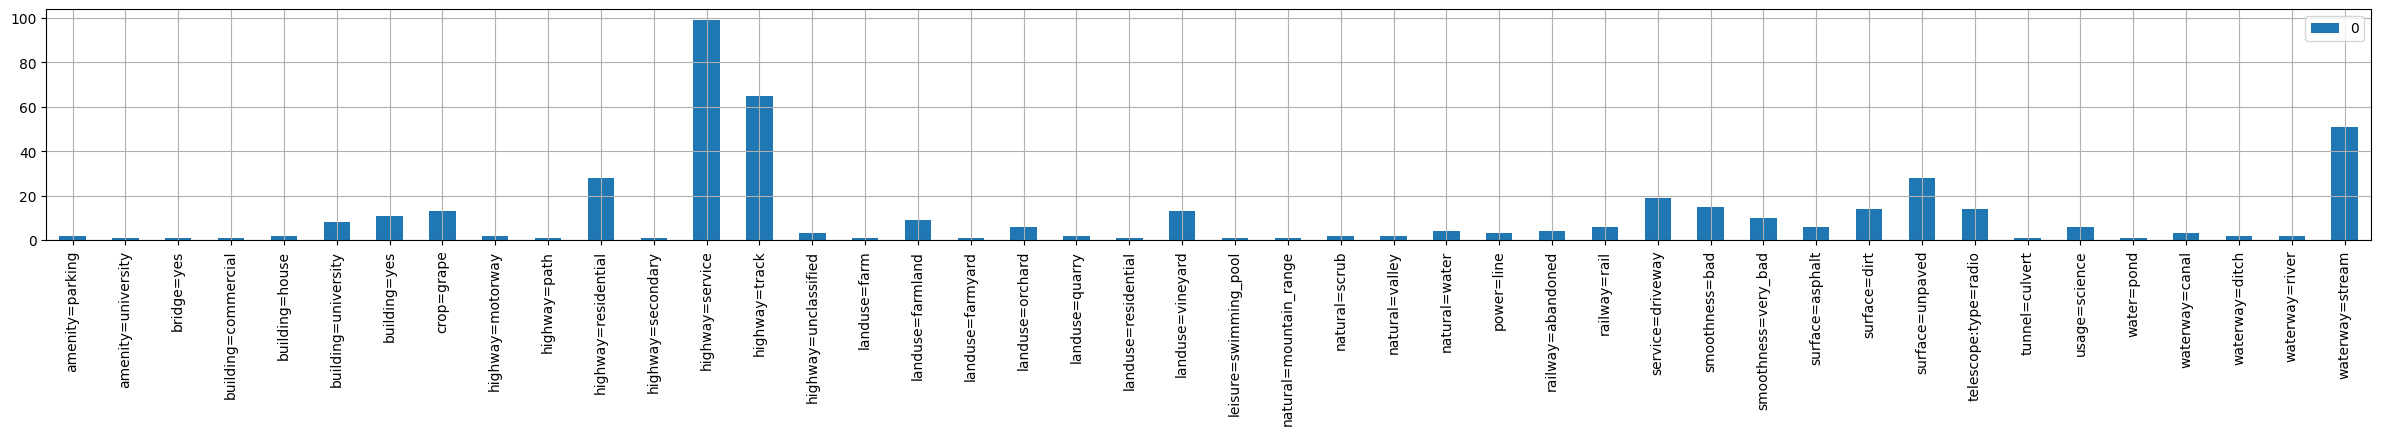

In [773]:
k.plot(kind='bar', figsize=(30,3))
import matplotlib.pyplot as plt
plt.grid();

In [ ]:
frames.explore()

In [ ]:
frames.explore(tiles='https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
               attr='esri')#,height = 500)


In [213]:
k = [pd.Series([f"{k}={v}" for k,v in t.items()]).value_counts() for t in z.tags]
k = pd.DataFrame(k).fillna(0).sum()
k

natural=volcano           2.0
volcano:status=dormant    2.0
volcano:type=scoria       2.0
highway=track             2.0
railway=abandoned         1.0
dtype: float64

In [ ]:
z.explore()

In [110]:
pd.DataFrame(k).fillna(0).sum()

highway=residential                     219.0
waterway=ditch                           19.0
waterway=stream                          23.0
intermittent=yes                         20.0
natural=water                             3.0
                                        ...  
description=vacant or disturbed land      1.0
surface=fine_gravel                       1.0
building=school                           6.0
crop=grape                                3.0
landuse=vineyard                          3.0
Length: 302, dtype: float64